In [2]:
import datetime
print('Last updated:', datetime.datetime.now(), '(PT)')

Last updated: 2020-07-15 15:09:31.279368 (PT)


In [3]:
import pystan
import numpy as np
import json
import matplotlib.pyplot as plt
import sys
sys.path.append('../../src/dp-gmm/util')
from pystan_vb_extract import pystan_vb_extract
import copy

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pystan

In [5]:
warped_mixture = """
data {
    int D;          // number of dimensions'
    int K;          // number of gaussians'
    int N;          // number of data'
    vector[D] y[N]; // data'
    vector[K] eta; // dirichlet parameter
    int degree; // number of units in hidden layer of neural net
}
parameters {
    simplex[K] w;             // mixing proportions'
    ordered[D] mu[K];             // mixture component means'
    cholesky_factor_corr[D] L[K]; // cholesky factor of covariance'
    vector[D] x[N]; // latent params
    real<lower=0> sigma;
    vector[degree] beta;
}
transformed parameters {
    vector[D] z[N];
    
    for (d in 1:D) {
        for (n in 1:N) {
            z[n][d] = 0.0;
            for (j in 1:degree) {
              z[n][d] += x[n][d] ^ (j - 1) * beta[j];
            }
        }
    }
}
model {
    real ps[K];
    
    w ~ dirichlet(eta);
    beta ~ normal(0, 1);
    
    for(k in 1:K){
       mu[k] ~ normal(0,3);
       L[k] ~ lkj_corr_cholesky(4);
    }
    for (n in 1:N){
       for (k in 1:K){
          // increment log probability of the gaussian'
          ps[k] = log(w[k]) + multi_normal_cholesky_lpdf(x[n] | mu[k], L[k]);
       }
       target += log_sum_exp(ps);
    }
    
    sigma ~ lognormal(-1, 1);
    for (n in 1:N) {
      y[n] ~ normal(z[n], sigma);
    }
}
"""

In [6]:
sm = pystan.StanModel(model_code=warped_mixture)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f4c8c89395ebff8034fec56aece83276 NOW.


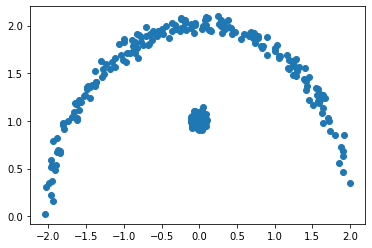

In [8]:
def gen_rainbow_data(N1=200, N2=100, r=2, s=0.1, sx=0.01, sy=0.01):
    x1 = np.random.rand(N1) * 2 * r - r
    y1 = np.sqrt(r*r - x1*x1)
    x2 = np.random.randn(N2) * sx
    y2 = np.random.randn(N2) * sy + 1
    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    z = np.stack([x, y], axis=1)
    return z + np.random.randn(N1 + N2, 2) * s

Z = gen_rainbow_data(s=0.05)
plt.scatter(Z[:, 0], Z[:, 1])

In [29]:
# Generate data
np.random.seed(1)
N1 = 100
N2 = 200

# Easy data
Y = np.vstack([np.random.randn(N1, 2) * .5 + 3,
               np.random.randn(N2, 2) - 2])

# Fun data
# plt.scatter(Y[:, 0], Y[:, 1])

# Data dictionary
K = 10
degree = 5
# data = dict(y=Y, D=Y.shape[1], N=Y.shape[0], 
#             K=K, eta=np.full(K, 1/K), degree=degree)

data = dict(y=Z, D=Z.shape[1], N=Z.shape[0], 
            K=K, eta=np.full(K, 1/K), degree=degree)

In [30]:
%%time
# Fit via ADVI
vb_fit = sm.vb(data=data, iter=2000, seed=2)

CPU times: user 8.48 s, sys: 32.3 ms, total: 8.51 s
Wall time: 8.47 s


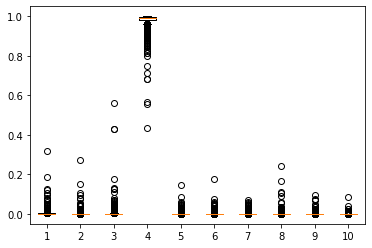

In [31]:
plt.boxplot(pystan_vb_extract(vb_fit)['w']);
# plt.boxplot(pystan_vb_extract(vb_fit)['mu']);
mu_mean = pystan_vb_extract(vb_fit)['mu'].mean(0)

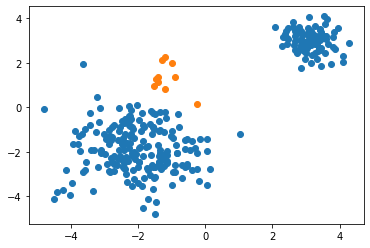

In [32]:
plt.scatter(Y[:, 0], Y[:, 1])
plt.scatter(mu_mean[:, 0], mu_mean[:, 1])

../../src/dp-gmm/util/pystan_vb_extract.py:21: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty((n, ) + tuple(shape))) for name, shape in param_shapes.items()])


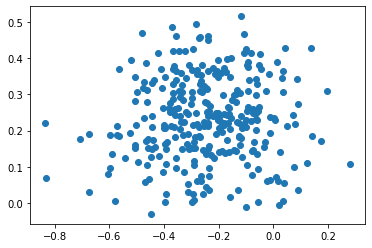

In [33]:
x = pystan_vb_extract(vb_fit)['x'].mean(0)
plt.scatter(x[:, 0], x[:, 1])